# An Analysis of the Degree of Difference between Music Genres

# 1. Load Song Metadata and Genre Data

**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, tree, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.classifier import ClassificationReport

%matplotlib inline

**Get feature matrix of song metadata <br>
via Columbia University & The Echo Nest's Million Song Dataset (track metadata link here: <br> https://labrosa.ee.columbia.edu/millionsong/pages/tasks-demos#automatictagging)**

In [2]:
import sqlite3
db = sqlite3.connect('Automatic Tagging/track_metadata.db')
songs = pd.read_sql_query("SELECT * from songs", db)

print("Song metadata shape: ", songs.shape)
print("Song metadata columns: ", songs.columns)

Song metadata shape:  (1000000, 11)
Song metadata columns:  Index(['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year'],
      dtype='object')


**Get target matrix of music genres <br>
from AllMusic.com via http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MASD-styleAssignment.cls**

In [3]:
genres_cols = ['track_id','genre']
genres = pd.read_csv('Genre mapping 13.txt', sep='\t',header=None,names=genres_cols)

print("Genre data shape: ", genres.shape)
print("Genre data columns: ", genres.columns)

Genre data shape:  (406427, 2)
Genre data columns:  Index(['track_id', 'genre'], dtype='object')


**Merge feature and target matrices**

In [4]:
songs_w_genre = songs.merge(genres, on='track_id', how='inner')
print("Merged data shape: ", songs_w_genre.shape)
print("Merged data columns: ", songs_w_genre.columns)

Merged data shape:  (406427, 12)
Merged data columns:  Index(['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid',
       'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'year', 'genre'],
      dtype='object')


# 2. Check and Clean Data

**Get column summary statistics**

In [5]:
songs_w_genre.describe(include='all')

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,genre
count,406427,406427,406427,406427,406427,406427,406427,406427.000000,406427.000000,406427.000000,406427.000000,406427
unique,406427,314371,405959,53483,22300,20775,22614,NaN,NaN,NaN,NaN,13
top,TRXLTKU12903CD191E,Intro,SOPYODE12A8C13EB37,Classic Masters,AR6CLFP1187B9ACB94,,Daniel Johnston,NaN,NaN,NaN,NaN,Pop_Rock
freq,1,701,3,122,124,15001,124,NaN,NaN,NaN,NaN,238786
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.170439,0.583255,0.397316,1283.987895,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.312157,0.128301,0.117872,958.494905,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495870,-1.000000,-1.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.637100,0.501873,0.348904,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.567710,0.581444,0.397257,1995.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.234650,0.665133,0.456728,2004.000000,NaN


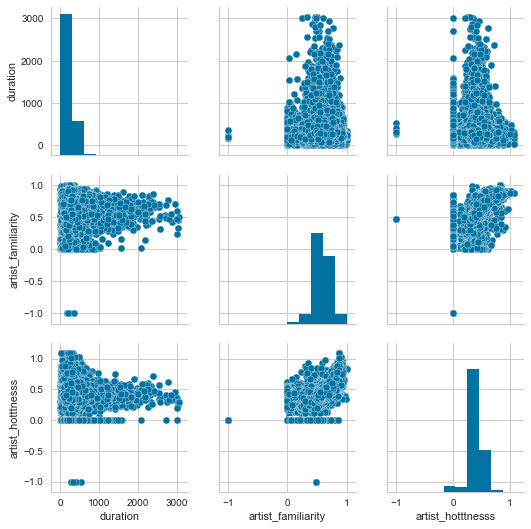

In [6]:
# Pairplot numeric features
sns.pairplot(songs_w_genre, x_vars = ['duration','artist_familiarity','artist_hotttnesss'], 
             y_vars = ['duration','artist_familiarity','artist_hotttnesss'])

**Drop duplicate songs**

In [7]:
# Drop songs with duplicate song_ids
# Can browse these using: songs_w_genre[songs_w_genre.duplicated(['song_id'], keep=False)].sort_values(by='song_id')
songs_w_genre_clean = songs_w_genre.drop_duplicates('song_id')
print("Song_id count: ", songs_w_genre_clean['song_id'].count())
print("Song_id unique: ", songs_w_genre_clean['song_id'].nunique())

Song_id count:  405959
Song_id unique:  405959


In [8]:
# Drop duplicates of duration, artist_id, and year (this drops a few non-duplicates too, but it's conservative to remove them)
# Can browse these using: songs_w_genre[songs_w_genre.duplicated(['duration','artist_name','year'], keep=False)].sort_values(by='duration')
songs_w_genre_clean2 = songs_w_genre_clean.drop_duplicates(['duration','artist_name','year'])
print("Song_id count: ", songs_w_genre_clean2['song_id'].count())

Song_id count:  404691


**View distribution of genres in the data**

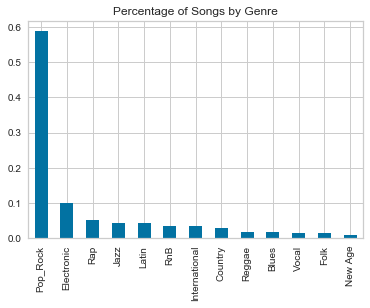

In [9]:
songs_w_genre_clean2['genre'].value_counts(normalize=True).plot(kind='bar')
plt.title('Percentage of Songs by Genre')

**Check that most artists have only one genre**

In [10]:
# Calculate genres per artist
genres_per_artist = pd.DataFrame(songs_w_genre_clean2.groupby('artist_name')['genre'].nunique().reset_index())
genres_per_artist.rename(columns={'genre':'genre_count'}, inplace=True)

In [11]:
# Can browse artists with more than more genre using this code:
# song_w_genre_clean_multgenre = songs_w_genre_clean2.merge(genres_per_artist, on='artist_name', how='left')
# song_w_genre_clean_multgenre[song_w_genre_clean_multgenre['genre_count']>1].sort_values('artist_name').head()

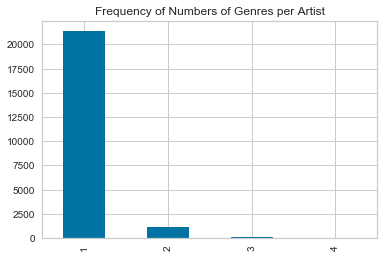

In [12]:
# Plot frequency of genres per artist
genres_per_artist['genre_count'].value_counts().plot(kind='bar')
plt.title('Frequency of Numbers of Genres per Artist')

**Drop missing values**

In [13]:
print("Shape prior to drop:", songs_w_genre_clean2.shape)

Shape prior to drop: (404691, 12)


In [14]:
# Drop -1 values of artist_familiarity and artist_hotttnesss
# Can browse songs with missing artist_familiarity using: songs_w_genre_clean2[songs_w_genre_clean2['artist_familiarity']<0]
# Can browse songs with missing artist_hotttnesss using: songs_w_genre_clean[songs_w_genre_clean['artist_hotttnesss']<0]
songs_w_genre_clean2 = songs_w_genre_clean2[songs_w_genre_clean2['artist_familiarity'] >= 0]
songs_w_genre_clean2 = songs_w_genre_clean2[songs_w_genre_clean2['artist_hotttnesss'] >= 0]
print("Shape with -1s dropped: ",songs_w_genre_clean2.shape)

Shape with -1s dropped:  (404669, 12)


# 3. Feature Engineering

In [15]:
# Add feature with length of artist name
songs_w_genre_clean2['artist_length'] = songs_w_genre_clean2['artist_name'].str.len()

In [16]:
# Add feature with length of song title name
songs_w_genre_clean2['title_length'] = songs_w_genre_clean2['title'].str.len()

In [17]:
# Add feature with length of album name
songs_w_genre_clean2['release_length'] = songs_w_genre_clean2['release'].str.len()

# 4. Exploratory Analysis

**Group data by artist for the purpose of predicting an artist's genre**

In [18]:
# Get most frequent genre for each artist (most artists have only one genre)
artist_genres = pd.DataFrame(songs_w_genre_clean2.groupby('artist_name')['genre'].
                             agg(lambda x: x.value_counts().index[0]).reset_index())

In [19]:
# Collapse feature data by mean/median to the artist level
artist_features = pd.DataFrame(songs_w_genre_clean2.groupby('artist_name').
                               agg({'duration':'median','artist_familiarity':'mean','artist_hotttnesss':'mean',
                                    'artist_length':'mean','title_length':'mean','release_length':'mean'}).
                               reset_index())

In [20]:
# Merge features and target at the artist level
artist_data = artist_features.merge(artist_genres, on='artist_name', how='inner')

print("Merged data shape: ", artist_data.shape)
print("Merged data columns: ", artist_data.columns)

Merged data shape:  (22612, 8)
Merged data columns:  Index(['artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss',
       'artist_length', 'title_length', 'release_length', 'genre'],
      dtype='object')


**View correlations**

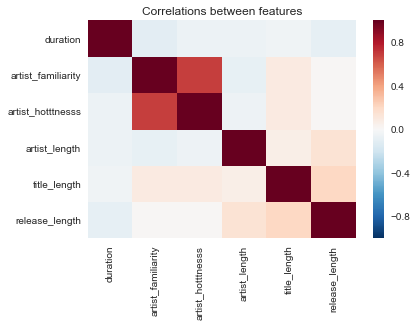

In [21]:
# Plot correlation heatmap
sns.heatmap(artist_data.corr())
plt.title('Correlations between features')

**View feature boxplots by genre**

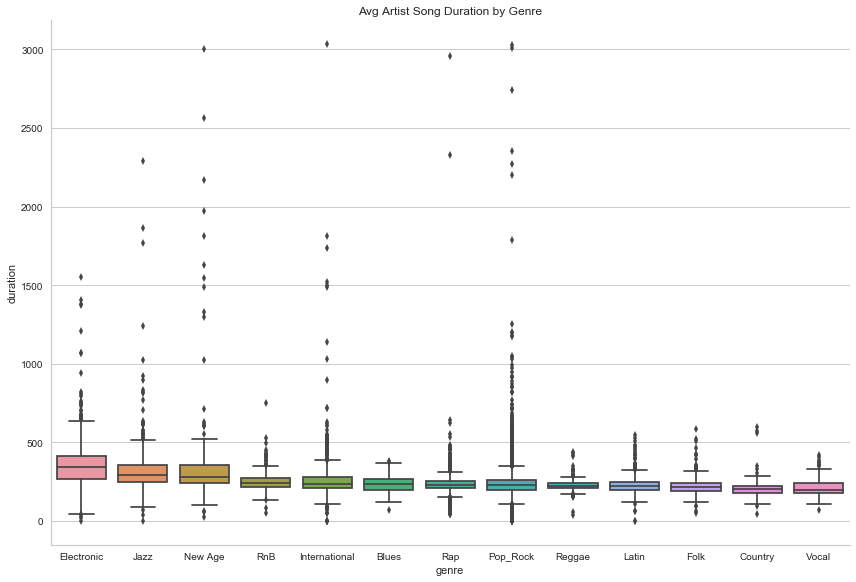

In [22]:
# Make boxplots of avg artist song duration, by genre
ranks = artist_data.groupby('genre')['duration'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='duration', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Avg Artist Song Duration by Genre')

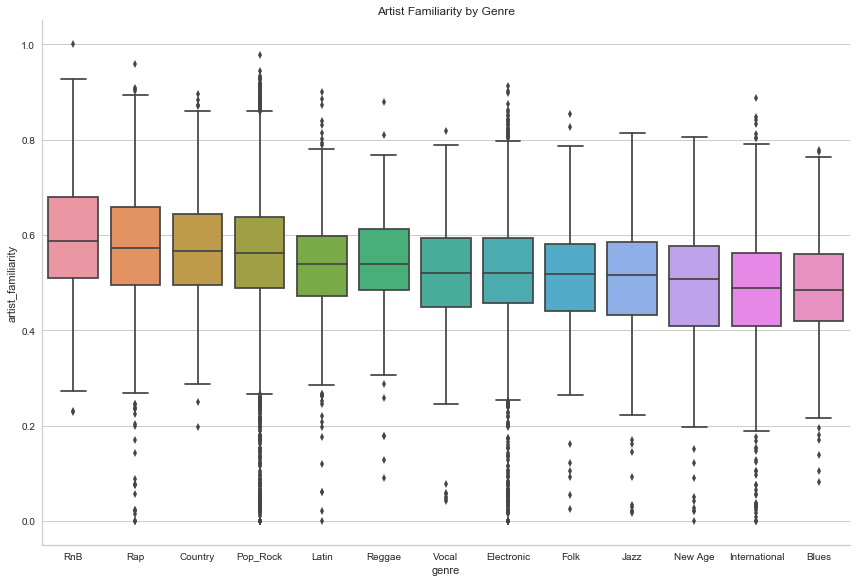

In [23]:
# Make boxplots of artist familiarity, by genre
ranks = artist_data.groupby('genre')['artist_familiarity'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='artist_familiarity', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Artist Familiarity by Genre')

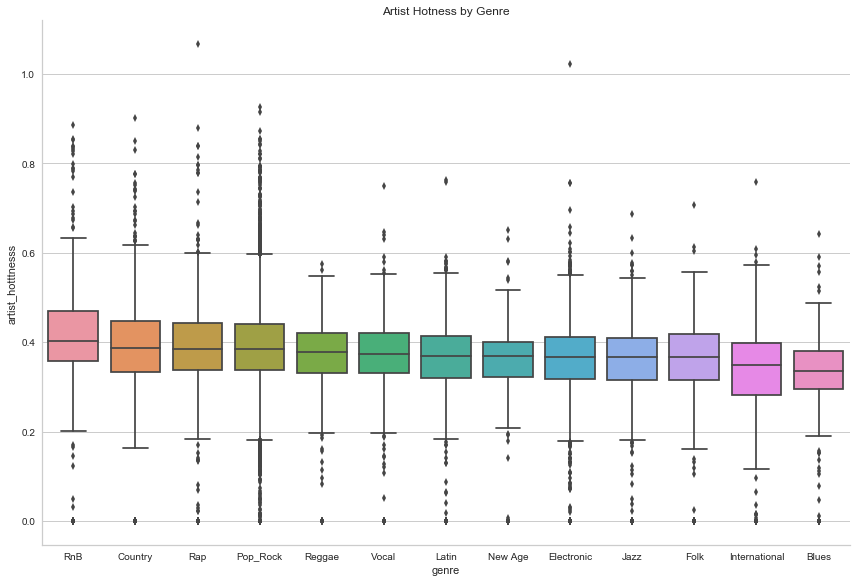

In [24]:
# Make boxplots of artist hotness, by genre
ranks = artist_data.groupby('genre')['artist_hotttnesss'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='artist_hotttnesss', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Artist Hotness by Genre')

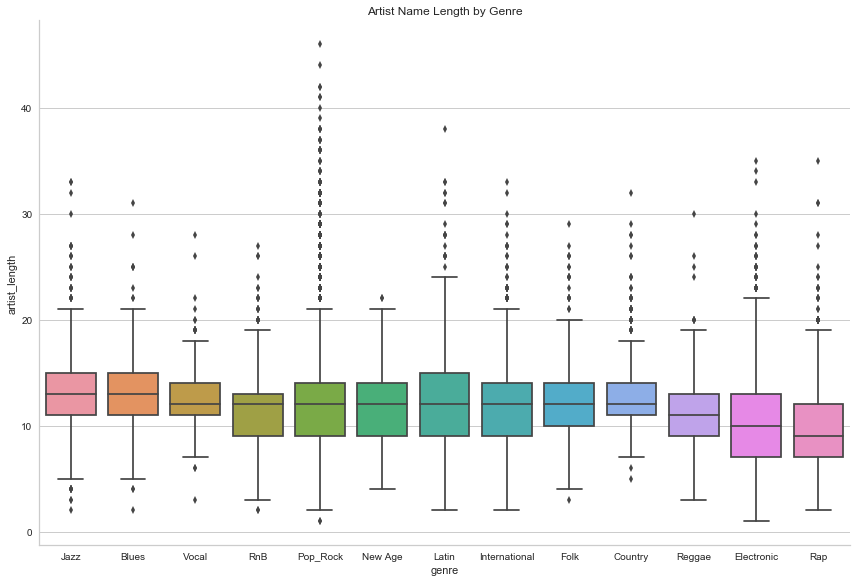

In [25]:
# Make boxplots of artist name length, by genre
ranks = artist_data.groupby('genre')['artist_length'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='artist_length', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Artist Name Length by Genre')

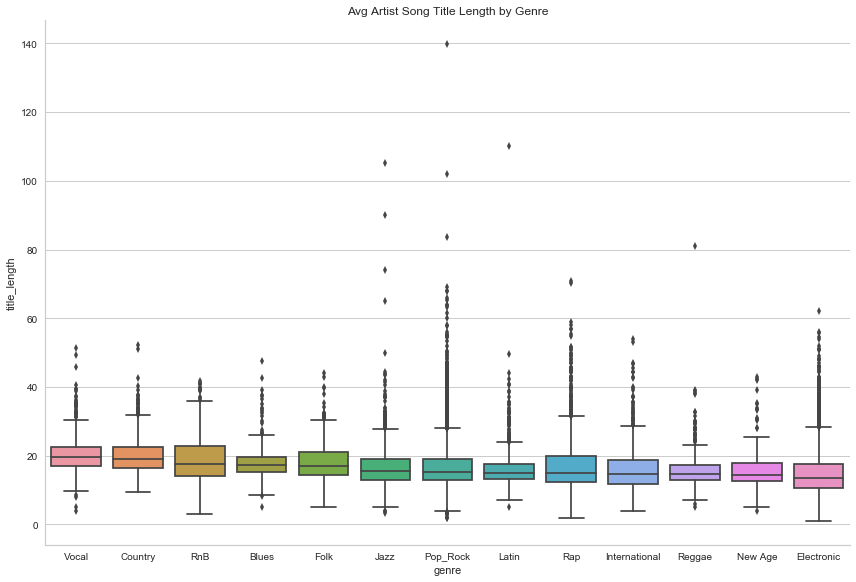

In [26]:
# Make boxplots of avg artist song title length, by genre
ranks = artist_data.groupby('genre')['title_length'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='title_length', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Avg Artist Song Title Length by Genre')

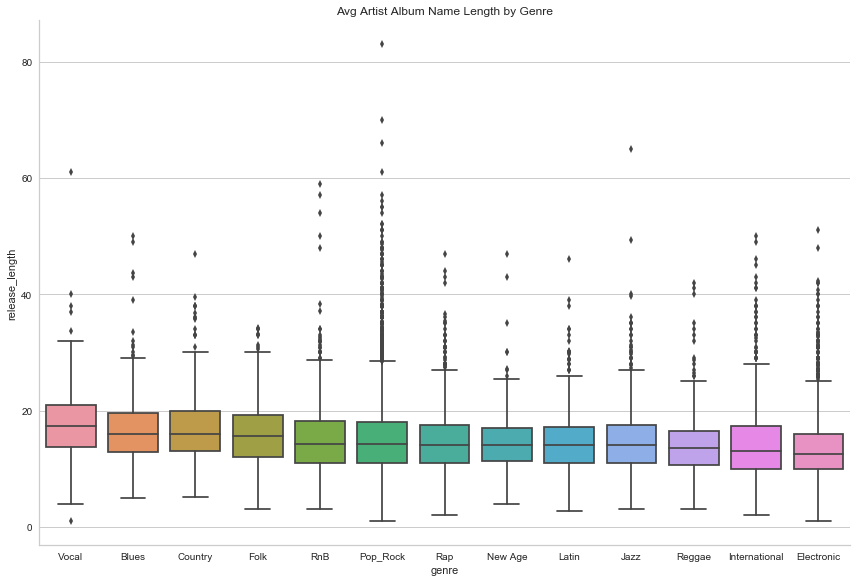

In [27]:
# Make boxplots of avg artist album name length, by genre
ranks = artist_data.groupby('genre')['release_length'].median().fillna(0).sort_values()[::-1].index
sns.factorplot(kind='box', y='release_length', x='genre', data=artist_data, size=8, aspect=1.5, order = ranks)
plt.title('Avg Artist Album Name Length by Genre')

# 5. Model to Predict an Artist's Genre

**There aren't many features, but there are a lot of genres, so let's simplify by trying to predict whether an artist's genre is pop rock or not.**

In [28]:
# Create binary target
artist_data['genre_elect'] = pd.DataFrame(artist_data['genre'] == 'Pop_Rock')
artist_data['genre_elect'].replace({True:'Pop_Rock',False:'Not Pop_Rock'}, inplace = True)

**Get null accuracy**

In [29]:
# Calculate share of largest class
artist_data['genre_elect'].value_counts(normalize=True)[0]

0.54356094109322484

**Set up X and y**

In [57]:
# Define X and y
song_features = ['duration','artist_familiarity','artist_hotttnesss','artist_length','title_length','release_length']
X = artist_data[song_features]
y = artist_data['genre_elect']

In [58]:
# Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

**Run Random Forest Classifier model**

In [59]:
# Run random forest classifier
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)

**Evaluate model**

In [60]:
# Get metrics
print("Test set accuracy: ", metrics.accuracy_score(y_test, y_preds))
print("Test set metrics:\n",metrics.classification_report(y_test,y_preds))

Test set accuracy:  0.62116745283
Test set metrics:
               precision    recall  f1-score   support

Not Pop_Rock       0.60      0.53      0.56      3107
    Pop_Rock       0.64      0.70      0.67      3677

 avg / total       0.62      0.62      0.62      6784



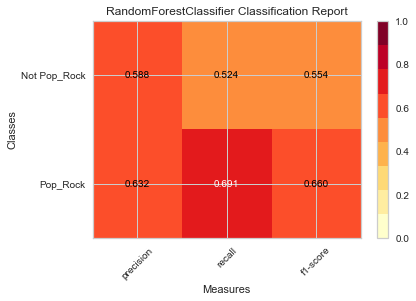

In [61]:
# Visualize metrics using yellowbrick
visualizer = ClassificationReport(rf) # Instantiate the visualizer
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

**Conclusions: <br>
Random forest was only mildly successful at predicting whether an artist's genre is Pop Rock or not (62% accuracy vs 54% null accuracy). I need to add additional features to my model to increase its accuracy.**

**However, we can learn about the relative feature importances from the random forest model.**

In [35]:
# Display feature importances
pd.DataFrame({'feature':song_features, 'importance':rf.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
0,duration,0.244263
1,artist_familiarity,0.173490
4,title_length,0.171809
2,artist_hotttnesss,0.166868
5,release_length,0.146503
3,artist_length,0.097067


# 6. Visualize Distance Between Genres

**We can visualize the distance between genres by graphing each genre's average features (scaled and reduced to 2D using PCA).**

**Get each genre's average features**

In [36]:
# Collapse data to the genre level, to get feature averages by genre
genre_stats = pd.DataFrame(artist_data.groupby('genre').
                           agg({'duration':'median','artist_familiarity':'mean','artist_hotttnesss':'mean',
                                'artist_length':'mean','title_length':'mean','release_length':'mean'}).reset_index())

**Scale features**

In [37]:
# Get feature matrix
genre_stats_x = genre_stats.drop('genre', axis=1)

In [38]:
# Scale the features
scaler = StandardScaler()
scaler.fit(genre_stats_x)
genre_stats_x_scaled = scaler.transform(genre_stats_x)

**Use PCA to reduce the features to 2D (for graphing)**

In [39]:
# Use PCA to reduce features
pca = PCA(n_components=2) #2-dimensional PCA
y_pca = pd.DataFrame(pca.fit_transform(genre_stats_x_scaled))

**Graph average features for each genre**

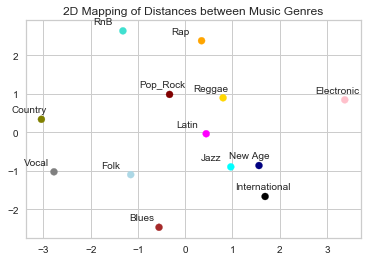

In [40]:
# Map colors on labels
dfcolor = pd.DataFrame([['Pop_Rock','maroon'],['Electronic','pink'],['Rap','orange'],['Jazz','cyan'],
                        ['Latin','magenta'],['RnB','turquoise'],['International','black'],['Country','olive'],
                        ['Reggae','gold'],['Blues','brown'],['Vocal','grey'],['Folk','lightblue'],['New Age','navy']],
                       columns=['genre','color'])
mergeddf = pd.merge(genre_stats,dfcolor,on='genre')

# Make graph
plt.scatter(y_pca[0],y_pca[1],color=mergeddf['color'])

# Add labels
for label, x, y in zip(mergeddf['genre'], y_pca[0], y_pca[1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-30, 7),
        textcoords= 'offset points')

plt.title('2D Mapping of Distances between Music Genres')    
plt.show()

# 7. Visualize Number of Common Listeners Between Genres

**Load additional listener and genre data**

In [41]:
# Get listener data
cols = ['user_id','song_id','play_count']
user_data = pd.read_csv('User Data/kaggle_visible_evaluation_triplets.txt', sep = '\t', header=None, names=cols)

print('Listener data shape', user_data.shape)

Listener data shape (1450933, 3)


In [42]:
# Get more granular genre data
genres_cols = ['track_id','genre']
genres25 = pd.read_csv('Genre mapping 25.txt', sep='\t',header=None,names=genres_cols)

In [43]:
# Merge with track_id
user_data_w_track_id = user_data.merge(songs, on='song_id', how='inner')

print('User data w track id shape:', user_data_w_track_id.shape)

User data w track id shape: (1491952, 13)


In [44]:
# Merge with genre
user_data_w_genre = user_data_w_track_id.merge(genres25, on='track_id', how='inner')

print('User data w genre shape: ', user_data_w_genre.shape)

User data w genre shape:  (642334, 14)


In [45]:
# Keep only needed columns
clean_user_data_w_genre = user_data_w_genre[['user_id','play_count','genre']]

**Calculate listener-genre pairs, removing any genre that a listener played only once**

In [46]:
# Collapse data to listener-genre level, summing play_counts
collapsed_user_data = pd.DataFrame(clean_user_data_w_genre.groupby(['user_id','genre'])['play_count'].sum().reset_index())
print('Collapsed user data shape: ', collapsed_user_data.shape)

Collapsed user data shape:  (377333, 3)


In [47]:
# Remove any genre that the listener played only once
collapsed_user_mult_plays = collapsed_user_data[collapsed_user_data['play_count']>1]

**Calculate number of overlapping listeners between genres**

In [48]:
# Reshape wide to display columns for each genre, by listener
user_pivot = collapsed_user_mult_plays.pivot(index='user_id', columns='genre', values='play_count')

In [49]:
# Drop if listener has only one genre
user_pivot['missing'] = user_pivot.isnull().sum(axis=1)
user_mult_gen = user_pivot[user_pivot['missing']<25]
user_mult_gen.drop('missing', axis=1, inplace=True)

In [50]:
# Generate all pairwise combinations of genres and flag listener overlaps
import itertools
pairwise_genres = pd.DataFrame({'{}-{}'.format(a, b): user_mult_gen[a] + user_mult_gen[b] 
                                for a, b in itertools.combinations(user_mult_gen.columns, 2)})

In [51]:
# Reshape long to a list of all combinations
pairwise_long = pd.melt(pairwise_genres)
pairwise_long.rename(columns={'value': 'listeners','variable':'genre_pair'}, inplace=True)

In [52]:
# Collapse data to sum the number of overlapping listeners by genre pair
pairwise_long_clean = pairwise_long[pairwise_long['listeners']>0]
pairwise_collapsed = pd.DataFrame(pairwise_long.groupby('genre_pair').count().reset_index())

In [53]:
# Format data to split the genre pair string between columns
pairwise_collapsed['genre1'], pairwise_collapsed['genre2'] = pairwise_collapsed['genre_pair'].str.split('-', 1).str

**Display the genre pairs with the most overlapping listeners**

In [54]:
print('The 10 genre pairs with the MOST overlapping listeners are:')
pairwise_collapsed[['listeners','genre1','genre2']].sort_values('listeners',ascending=False).head(10)

The 10 genre pairs with the MOST overlapping listeners are:


,listeners,genre1,genre2
260,5751,Pop_Indie,Rock_College
252,5089,Pop_Contemporary,Rock_Contemporary
294,4981,Rock_College,Rock_Contemporary
251,4408,Pop_Contemporary,Rock_College
219,4397,Metal_Alternative,Rock_Contemporary
211,4269,Metal_Alternative,Pop_Contemporary
218,4252,Metal_Alternative,Rock_College
166,4104,Grunge_Emo,Metal_Alternative
184,4081,Hip_Hop_Rap,Pop_Contemporary
261,3975,Pop_Indie,Rock_Contemporary


**Make chord diagram of overlapping listeners**

In [55]:
# Make one overlap = 500 overlapping users so that the diagram has fewer lines and is easier to read
pairwise_collapsed['reduced_listeners'] = pairwise_collapsed['listeners'] / 500 
pairwise_collapsed['rounded_reduced'] = pairwise_collapsed['reduced_listeners'].round(0)

In [56]:
# Make chord diagram
from bokeh.charts import output_notebook, Chord
from bokeh.io import show

chord_from_df = Chord(pairwise_collapsed, source="genre1", target="genre2", value="rounded_reduced")
output_notebook()
show(chord_from_df)

Loading BokehJS ...

**Make a heatmap of genres' listener overlaps**

In [91]:
# Return to wide data to generate all pairwise PERMUTATIONS of genres and flag listener overlaps
import itertools
heatmap_pairwise_genres = pd.DataFrame({'{}-{}'.format(a, b): user_mult_gen[a] + user_mult_gen[b] 
                                for a, b in itertools.permutations(user_mult_gen.columns, 2)})

In [92]:
# Reshape long to a list of all combinations
heatmap_pairwise_long = pd.melt(heatmap_pairwise_genres)

In [95]:
# Collapse data to sum the number of overlapping listeners by genre pair
heatmap_collapsed = pd.DataFrame(heatmap_pairwise_long.groupby('variable').count().reset_index())
heatmap_collapsed.rename(columns={'value': 'listeners','variable':'genre_pair'}, inplace=True)

In [97]:
# Split the genre pair string between columns
heatmap_collapsed['genre1'], heatmap_collapsed['genre2'] = heatmap_collapsed['genre_pair'].str.split('-', 1).str
heatmap_collapsed.drop(['genre_pair'], axis=1, inplace=True)

In [98]:
# Reshape wide to display genre1 vertically and genre2 horizontally
genre_grid = heatmap_collapsed.pivot(index='genre1', columns='genre2', values='listeners')

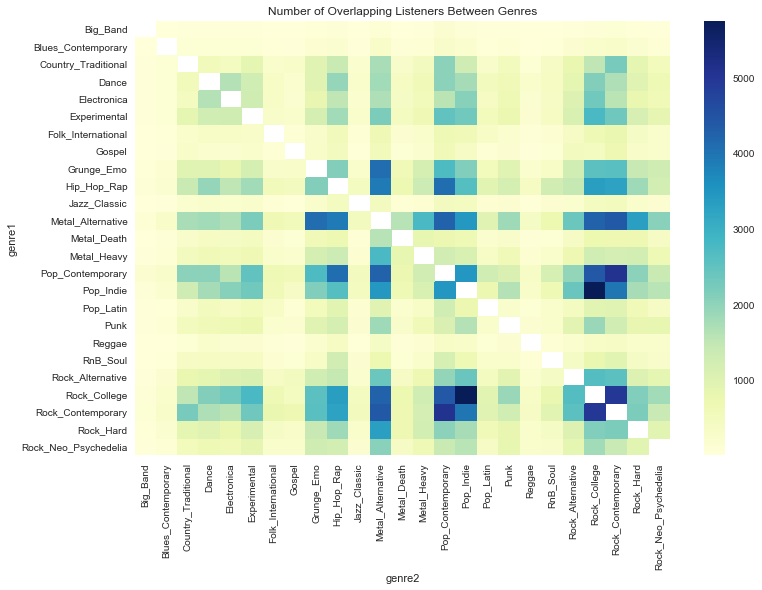

In [110]:
# Make heatmap
plt.figure(figsize=(12,8))
plt.title('Number of Overlapping Listeners Between Genres')
sns.heatmap(genre_grid, cmap="YlGnBu")

# 8. Further Work

**Primarily, the model and visualizations above can be improved by adding additional features.**

**Here are additional tasks to consider:** <br>
1) Do I need to address the imbalance between the classes? <br>
2) Add additional genres from other available genre datasets <br>
3) Double check for missing values and clean up treatment of them <br>
4) Clean up the dataset names <br>
5) Examine KNN's performance on the testing data for varying values of k <br>
6) Tune model parameters <br>
7) Plot AUC <br>
8) Additional feature engineering <br>
9) Find out how artist_familiarity and artist_hotttnesss are calculated <br>
10) Check if artist_name is unique - maybe use ID instead <br>
11) Are there issues if my features are too multi-collinear? <br>
12) Add genre size based on share to 2D plot <br>
13) Clean up GitHub repository <br>
14) Add k-fold cross validation

# 9. Archive of unused code to be revisited

In [ ]:
#import h5py
#filename = 'https://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/msd_summary_file.h5'
#f = h5py.File(filename, 'r')

#import hdf5_getters
#h5 = hdf5_getters.open_h5_file_read('https://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/msd_summary_file.h5')
#duration = hdf5_getters.get_duration(h5)
#h5.close()

#import hdf5_getters
#h5 = hdf5_getters.open_h5_file_read("C:/Users/azimmermann/Desktop/Music Genre Viz/MillionSongSubset/AdditionalFiles/subset_msd_summary_file.h5")

#df = pd.read_csv('https://github.com/Taranveer/Million_Song_dataset/blob/master/song_dataset.csv')

Scale features and run KNN model

In [ ]:
scaler = StandardScaler() #create a scaler object
scaler.fit(X_train) #fit the scaler
X_train_scaled = scaler.transform(X_train) #transform the training data with it
X_test_scaled = scaler.transform(X_test) #transform the testing data with it

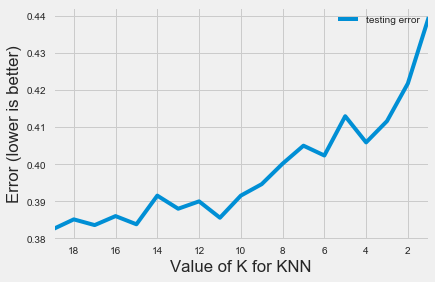

In [304]:
k_range = range(1, 20)
testing_error = []

for k in k_range:
    knn_ss = KNeighborsClassifier(n_neighbors=k)
    knn_ss.fit(X_train_scaled, y_train)
    y_preds = knn_ss.predict(X_test_scaled)
    testing_accuracy = metrics.accuracy_score(y_test, y_preds)
    testing_error.append(1 - testing_accuracy)

plt.style.use('fivethirtyeight')
# create a DataFrame of K, training error, and testing error
column_dict = {'K': k_range, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
df.plot(y='testing error')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error (lower is better)')

In [305]:
knn_ss = KNeighborsClassifier(n_neighbors=11)
knn_ss.fit(X_train_scaled, y_train)
y_preds = knn_ss.predict(X_test_scaled)
print("Test set accuracy:",metrics.accuracy_score(y_test, y_preds))
print("Test set metrics:\n",metrics.classification_report(y_test,y_preds))

Test set accuracy: 0.614415211143
Test set metrics:
                 precision    recall  f1-score   support

    Electronic       0.62      0.72      0.67      2427
Not Electronic       0.60      0.49      0.54      2096

   avg / total       0.61      0.61      0.61      4523

